# Experiment Deep ResUNet
#### Setup:
**Dataset**: 3 different types of brain tumors <br>
**Loss function**: Dice loss <br>
**Optimizer**: Adam <br>
**Model**: Deep ResUNet

### Check if you are using GPU

In [ ]:
!nvidia-smi

Sun May 23 06:44:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Mount Directory to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
"""
# your workspace in your drive
workspace = 'DLMI_Final'


try:
  os.chdir(os.path.join('/content/gdrive/My Drive/', workspace))
except:
  os.mkdir(os.path.join('/content/gdrive/My Drive/', workspace))
  os.chdir(os.path.join('/content/gdrive/My Drive/', workspace))
"""

# /content/gdrive/My Drive/DLMI_Final/

Mounted at /content/gdrive


"\n# your workspace in your drive\nworkspace = 'DLMI_Final'\n\n\ntry:\n  os.chdir(os.path.join('/content/gdrive/My Drive/', workspace))\nexcept:\n  os.mkdir(os.path.join('/content/gdrive/My Drive/', workspace))\n  os.chdir(os.path.join('/content/gdrive/My Drive/', workspace))\n"

### Fix Random Seed

In [ ]:
import numpy as np
import random
import torch

def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(36963)

### Import Basic Package

In [ ]:
# Imports and training parameters
import torch
from torchvision.transforms import transforms
#from src.datasets import BrainTumorDatasetMask
#from src.loss import  dice_loss
#from src.metrics import dice_coeff
#from src.models import  DeepResUNet
#from src.trainers import Trainer
torch.manual_seed(0)
num_epochs = 100
batch_size = 16
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Implement Brain Tumor Dataset (with Mask)

In [ ]:
!pip install hdf5storage

     |████████████████████████████████| 61kB 5.9MB/s 


In [ ]:
import urllib.request
import os
import re
from tqdm import tqdm
import zipfile
import hdf5storage

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, target_folder, filename):
    # check if data exists
    print("Check if data exists on disk")
    if not os.path.isdir(target_folder):
      print("Creating target folder")
      os.mkdir(target_folder)
    files = os.listdir(target_folder)
    if not files:
        print("Cannot find files on disk")
        print("Downloading files")
        with DownloadProgressBar(unit='B', unit_scale=True,
                                 miniters=1, desc=url.split('/')[-1]) as t:
            urllib.request.urlretrieve(url, filename=target_folder + filename, reporthook=t.update_to)
    print("Download completed!")

def unzip_all_files(target_folder):
    print("Unzip files")
    items = os.listdir(target_folder)
    while(any(item.endswith('.zip') for item in items)):
        for item in filter(lambda item: item.endswith('.zip'), items):
            with zipfile.ZipFile(target_folder + item, "r") as zip_ref:
                zip_ref.extractall(target_folder)
        for item in items:
            if item.endswith(".zip"):
                os.remove(target_folder + item)
        items = os.listdir(target_folder)
    print("Unzip completed!")

def convert_landmark_to_bounding_box(landmark):
    x_min = x_max = y_min = y_max = None
    for x, y in landmark:
        if x_min is None:
            x_min = x_max = x
            y_min = y_max = y
        else:
            x_min, x_max = min(x, x_min), max(x, x_max)
            y_min, y_max = min(y, y_min), max(y, y_max)
    return [int(x_min), int(x_max), int(y_min), int(y_max)]

def _arrange_brain_tumor_data(root):
    # Remove and split files
    items = [item for item in filter(lambda item: re.search("^[0-9]+\.mat$", item), os.listdir(root))]
    try:
        os.mkdir(root + 'meningioma/')
    except:
        print("Meningioma directory already exists")
    try:
        os.mkdir(root + 'glioma/')
    except:
      print("Glioma directory already exists")
    try:
        os.mkdir(root + 'pituitary/')
    except:
        print("Pituitary directory already exists")

    for item in items:
        sample = hdf5storage.loadmat(root + item)['cjdata'][0]
        if sample[2].shape[0] == 512:
            if sample[0] == 1:
                os.rename(root + item, root + 'meningioma/' + item)
            if sample[0] == 2:
                os.rename(root + item, root + 'glioma/' + item)
            if sample[0] == 3:
                os.rename(root + item, root + 'pituitary/' + item)
        else:
            os.remove(root + item)

def get_data_if_needed(data_path='./data/', url="https://ndownloader.figshare.com/articles/1512427/versions/5"):
    if os.path.isdir(data_path):
        print("Data directory already exists. ",
              "if from some reason the data directory structure is wrong please remove the data dir and rerun this script")
        return
    filename = "all_data.zip"
    download_url(url, data_path, filename)
    unzip_all_files(data_path)
    _arrange_brain_tumor_data(data_path)

In [ ]:
from torch.utils.data import Dataset
#from src.utils.data import get_data_if_needed, convert_landmark_to_bounding_box
from torchvision.transforms import ToPILImage
import os
import math
import hdf5storage
from enum import Enum


class ClassesLabels(Enum):
    Meningioma = 1
    Glioma = 2
    Pituitary = 3

    def __len__(self):
        return 3


class BrainTumorDataset(Dataset):
    """
        This brain tumor dataset containing 3064 T1-weighted contrast-inhanced images
        from 233 patients with three kinds of brain tumor: meningioma (708 slices),
        glioma (1426 slices), and pituitary tumor (930 slices). Due to the file size
        limit of repository, we split the whole dataset into 4 subsets, and achive
        them in 4 .zip files with each .zip file containing 766 slices.The 5-fold
        cross-validation indices are also provided.

        -----
            This data is organized in matlab data format (.mat file). Each file stores a struct
            containing the following fields for an image:

            label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
            PID: patient ID
            image: image data
            tumorBorder: a vector storing the coordinates of discrete points on tumor border.
                    For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
                    It was generated by manually delineating the tumor border. So we can use it to generate
                    binary image of tumor mask.
            tumorMask: a binary image with 1s indicating tumor region

        -----
        taken from https://figshare.com/articles/brain_tumor_dataset/1512427 all right reserved to
            Jun Cheng
            School of Biomedical Engineering
            Southern Medical University, Guangzhou, China
            Email: chengjun583@qq.com
        -----
    """

    def __init__(self, root, train=True, download=True,
                                                  classes=(ClassesLabels.Meningioma,
                                                  ClassesLabels.Glioma,
                                                  ClassesLabels.Pituitary)):
        super().__init__()
        test_fr = 0.15
        if download:
            get_data_if_needed(root)
        self.root = root
        # List all data files
        items = []
        if ClassesLabels.Meningioma in classes:
            items += ['meningioma/' + item for item in os.listdir(root + 'meningioma/')]
        if ClassesLabels.Glioma in classes:
            items += ['glioma/' + item for item in os.listdir(root + 'glioma/')]
        if ClassesLabels.Meningioma in classes:
            items += ['pituitary/' + item for item in os.listdir(root + 'pituitary/')]

        if train:
            self.items = items[0:math.floor((1-test_fr) * len(items)) + 1]
        else:
            self.items = items[math.floor((1-test_fr) * len(items)) + 1:]

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        """
        Get the data item
            label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
            PID: patient ID
            image: image data
            tumorBorder: a vector storing the coordinates of discrete points on tumor border.
                    For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
                    It was generated by manually delineating the tumor border. So we can use it to generate
                    binary image of tumor mask.
            tumorMask: a binary image with 1s indicating tumor region
            And convert it to more convenient python dict object
        :param idx: index of item between 0 to len(self.item) - 1
        :return: dict - {label: int, image: matrix, landmarks: array of tuple (x, y), mask: matrix, bounding_box 4 size array of (x, y)}
        """
        if not (0 <= idx <  len(self.items)):
            raise IndexError("Idx out of bound")

        data = hdf5storage.loadmat(self.root + self.items[idx])['cjdata'][0]
        # transform the tumor border to array of (x, y) tuple
        xy = data[3]
        landmarks = []
        for i in range(0, len(xy), 2):
            x = xy[i][0]
            y = xy[i + 1][0]
            landmarks.append((x, y))
        mask = data[4]
        data[2].dtype = 'uint16'
        image_with_metadata = {
            "label": int(data[0][0]),
            "image": ToPILImage()(data[2]),
            "landmarks": landmarks,
            "mask": mask,
            "bounding_box": convert_landmark_to_bounding_box(landmarks)
        }
        return image_with_metadata


class BrainTumorDatasetMask(BrainTumorDataset):
    def __init__(self, root, train=True, transform=None, classes=(ClassesLabels.Meningioma,
                                                  ClassesLabels.Glioma,
                                                  ClassesLabels.Pituitary)):
        super().__init__(root, train, classes=classes)
        self.transform = transform

    def __getitem__(self, idx):
        item = super().__getitem__(idx)
        sample = (item["image"], item["mask"])
        return sample if self.transform is None else self.transform(*sample)


### Implement loss function of Dice

In [ ]:
def dice_loss(pred, target, epsilon=1e-7, use_sigmoid=True):
    pred = pred.contiguous()
    if use_sigmoid:
        pred = torch.sigmoid(pred)
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + epsilon) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + epsilon)))
    return loss.mean()

In [ ]:
def dice_coeff(pred, target, threshold=0.5, epsilon=1e-6, use_sigmoid = True):
    # make sure the tensors are align in memory and convert to probabilities if needed
    pred = pred.contiguous()
    if use_sigmoid:
        pred = torch.sigmoid(pred)
    target = target.contiguous()

    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + epsilon) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + epsilon)
    return dice.mean()

### Define DeepResUNet

In [ ]:
import torch.nn as nn

class PreActivateDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PreActivateDoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.double_conv(x)

class PreActivateResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PreActivateResBlock, self).__init__()
        self.ch_avg = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))

        self.double_conv = PreActivateDoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        identity = self.ch_avg(x)
        out = self.double_conv(x)
        out = out + identity
        return self.down_sample(out), out

class PreActivateResUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PreActivateResUpBlock, self).__init__()
        self.ch_avg = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.ch_avg = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))
        self.double_conv = PreActivateDoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x) + self.ch_avg(x)

In [ ]:
class DeepResUNet(nn.Module):
    def __init__(self, out_classes=1):
        super(DeepResUNet, self).__init__()

        self.down_conv1 = PreActivateResBlock(1, 64)
        self.down_conv2 = PreActivateResBlock(64, 128)
        self.down_conv3 = PreActivateResBlock(128, 256)
        self.down_conv4 = PreActivateResBlock(256, 512)

        self.double_conv = PreActivateDoubleConv(512, 1024)

        self.up_conv4 = PreActivateResUpBlock(512 + 1024, 512)
        self.up_conv3 = PreActivateResUpBlock(256 + 512, 256)
        self.up_conv2 = PreActivateResUpBlock(128 + 256, 128)
        self.up_conv1 = PreActivateResUpBlock(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

### Define Training Module(Trainer)

In [ ]:
import abc
import os
import sys
import tqdm
import torch
import datetime

from torch.utils.data import DataLoader
from typing import Callable, Any
from typing import NamedTuple, List
from torchvision.utils import make_grid

def to_np(x):
    return x.data.cpu().numpy()

class BatchResult(NamedTuple):
    """
    Represents the result of training for a single batch: the loss
    and score of the batch.
    """
    loss: float
    score: float


class EpochResult(NamedTuple):
    """
    Represents the result of training for a single epoch: the loss per batch
    and accuracy on the dataset (train or test).
    """
    losses: List[float]
    score: float


class FitResult(NamedTuple):
    """
    Represents the result of fitting a model for multiple epochs given a
    training and test (or validation) set.
    The losses are for each batch and the accuracies are per epoch.
    """
    num_epochs: int
    train_loss: List[float]
    train_acc: List[float]
    test_loss: List[float]
    test_acc: List[float]
    best_score: float

class Trainer:
    """
    A class abstracting the various tasks of training models.

    Provides methods at multiple levels of granularity:
    - Multiple epochs (fit)
    - Single epoch (train_epoch/test_epoch)
    - Single batch (train_batch/test_batch)
    """
    def __init__(self,
                 model,
                 loss_fn,
                 optimizer,
                 objective_metric,
                 device="cuda",
                 tensorboard_logger=None,
                 tensorboard_log_images=True,
                 experiment_prefix=None):
        """
        Initialize the trainer.
        :param model: Instance of the model to train.
        :param loss_fn: The loss function to evaluate with.
        :param optimizer: The optimizer to train with.
        :param device: torch.device to run training on (CPU or GPU).
        :param tensorboard_logger: tensordboard logger.
        """
        self.tensorboard_logger = tensorboard_logger

        if experiment_prefix is None:
            now = datetime.datetime.now()
            self.experiment_prefix = now.strftime("%Y-%m-%d\%H:%M:%S")
        else:
            self.experiment_prefix = experiment_prefix
        self.tensorboard_log_images = tensorboard_log_images
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.objective_metric = objective_metric
        self.device = device

        if self.device:
            model.to(self.device)

    def fit(self, dl_train: DataLoader, dl_test: DataLoader,
            num_epochs, checkpoints: str = None,
            early_stopping: int = None,
            print_every=1, **kw) -> FitResult:
        """
        Trains the model for multiple epochs with a given training set,
        and calculates validation loss over a given validation set.
        :param dl_train: Dataloader for the training set.
        :param dl_test: Dataloader for the test set.
        :param num_epochs: Number of epochs to train for.
        :param checkpoints: Whether to save model to file every time the
            test set accuracy improves. Should be a string containing a
            filename without extension.
        :param early_stopping: Whether to stop training early if there is no
            test loss improvement for this number of epochs.
        :param print_every: Print progress every this number of epochs.
        :return: A FitResult object containing train and test losses per epoch.
        """
        try:
          os.mkdir(checkpoints)
        except:
          print("checkpoints directory already exists")

        actual_num_epochs = 0
        train_loss, train_acc, test_loss, test_acc = [], [], [], []

        best_score = None
        epochs_without_improvement = 0

        for epoch in range(num_epochs):
            verbose = False  # pass this to train/test_epoch.
            if epoch % print_every == 0 or epoch == num_epochs-1:
                verbose = True
            self._print(f'--- EPOCH {epoch+1}/{num_epochs} ---', verbose)

            epoch_train_res = self.train_epoch(dl_train, verbose=verbose, **kw)
            train_loss.extend([float(x.item()) for x in epoch_train_res.losses])
            train_acc.append(float(epoch_train_res.score))

            epoch_test_res = self.test_epoch(dl_test, verbose=verbose, **kw)
            test_loss.extend([float(x.item()) for x in epoch_test_res.losses])
            test_acc.append(float(epoch_test_res.score))

            if best_score is None:
                best_score = epoch_test_res.score
            elif epoch_test_res.score > best_score:
                best_score = epoch_test_res.score
                if checkpoints is not None:
                    torch.save(self.model, checkpoints)
                    print("**** Checkpoint saved ****")
                epochs_without_improvement = 0
            else:
                if early_stopping is not None and epochs_without_improvement >= early_stopping:
                    print("Early stopping after %s with out improvement" % epochs_without_improvement)
                    break
                epochs_without_improvement += 1

            # ========================

        return FitResult(actual_num_epochs,
                         train_loss, train_acc, test_loss, test_acc, best_score)

    def train_epoch(self, dl_train: DataLoader, **kw) -> EpochResult:
        """
        Train once over a training set (single epoch).
        :param dl_train: DataLoader for the training set.
        :param kw: Keyword args supported by _foreach_batch.
        :return: An EpochResult for the epoch.
        """
        self.model.train()  # set train mode
        return self._foreach_batch(dl_train, self.train_batch, **kw)

    def test_epoch(self, dl_test: DataLoader, **kw) -> EpochResult:
        """
        Evaluate model once over a test set (single epoch).
        :param dl_test: DataLoader for the test set.
        :param kw: Keyword args supported by _foreach_batch.
        :return: An EpochResult for the epoch.
        """
        self.model.eval()  # set evaluation (test) mode
        return self._foreach_batch(dl_test, self.test_batch, **kw)

    def train_batch(self, index, batch_data) -> BatchResult:
        """
        Runs a single batch forward through the model, calculates loss,
        preforms back-propagation and uses the optimizer to update weights.
        :param batch: A single batch of data  from a data loader (might
            be a tuple of data and labels or anything else depending on
            the underlying dataset.
        :return: A BatchResult containing the value of the loss function and
            the number of correctly classified samples in the batch.
        """

        X, y = batch_data
        if self.tensorboard_logger and self.tensorboard_log_images:
            B = torch.zeros_like(X.squeeze())
            C = torch.stack([B, X.squeeze(), X.squeeze()])
            C = C.unsqueeze(dim=0)
            images = C
            grid = make_grid(images, normalize=True, scale_each=True)
            self.tensorboard_logger.add_image("exp-%s/batch/test/images" % self.experiment_prefix, grid, index)
        if isinstance(X, tuple) or isinstance(X, list):
            X = [x.to(self.device) for x in X]
        else:
            X = X.to(self.device)
        y = y.to(self.device)
        pred = self.model(X)
        loss = self.loss_fn(pred, y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        score = self.objective_metric(pred, y)
        if self.tensorboard_logger:
            self.tensorboard_logger.add_scalar('exp-%s/batch/train/loss' % self.experiment_prefix, loss, index)
            self.tensorboard_logger.add_scalar('exp-%s/batch/train/score' % self.experiment_prefix, score, index)
            if index % 300 == 0:
                for tag, value in self.model.named_parameters():
                    tag = tag.replace('.', '/')
                    self.tensorboard_logger.add_histogram('exp-%s/batch/train/param/%s' % (self.experiment_prefix, tag), to_np(value), index)
                    self.tensorboard_logger.add_histogram('exp-%s/batch/train/param/%s/grad' % (self.experiment_prefix, tag), to_np(value.grad), index)

        return BatchResult(loss, score)

    def test_batch(self, index, batch_data) -> BatchResult:
        """
        Runs a single batch forward through the model and calculates loss.
        :param batch: A single batch of data  from a data loader (might
            be a tuple of data and labels or anything else depending on
            the underlying dataset.
        :return: A BatchResult containing the value of the loss function and
            the number of correctly classified samples in the batch.
        """
        with torch.no_grad():
            X, y = batch_data
            if isinstance(X, tuple) or isinstance(X, list):
                X = [x.to(self.device) for x in X]
            else:
                X = X.to(self.device)
            y = y.to(self.device)
            pred = self.model(X)
            loss = self.loss_fn(pred, y)
            score = self.objective_metric(pred, y)
            if self.tensorboard_logger:
                self.tensorboard_logger.add_scalar('exp-%s/batch/test/loss' % self.experiment_prefix, loss, index)
                self.tensorboard_logger.add_scalar('exp-%s/batch/test/score' % self.experiment_prefix, score, index)
            return BatchResult(loss, score)

    @staticmethod
    def _print(message, verbose=True):
        """ Simple wrapper around print to make it conditional """
        if verbose:
            print(message)

    @staticmethod
    def _foreach_batch(dl: DataLoader,
                       forward_fn: Callable[[Any], BatchResult],
                       verbose=True, max_batches=None) -> EpochResult:
        """
        Evaluates the given forward-function on batches from the given
        dataloader, and prints progress along the way.
        """
        losses = []
        num_samples = len(dl.sampler)
        num_batches = len(dl.batch_sampler)

        if max_batches is not None:
            if max_batches < num_batches:
                num_batches = max_batches
                num_samples = num_batches * dl.batch_size

        if verbose:
            pbar_file = sys.stdout
        else:
            pbar_file = open(os.devnull, 'w')

        pbar_name = forward_fn.__name__
        with tqdm.tqdm(desc=pbar_name, total=num_batches,
                       file=pbar_file) as pbar:
            dl_iter = iter(dl)
            overall_score = overall_loss = avg_score = avg_loss = counter = 0
            min_loss = min_score = 1
            max_loss = max_score = 0
            for batch_idx in range(num_batches):
                counter += 1
                data = next(dl_iter)
                batch_res = forward_fn(batch_idx, data)
                if batch_res.loss > max_loss:
                    max_loss = batch_res.loss
                if batch_res.score > max_score:
                    max_score = batch_res.score

                if batch_res.loss < min_loss:
                    min_loss = batch_res.loss
                if batch_res.score < min_score:
                    min_score = batch_res.score
                overall_loss += batch_res.loss
                overall_score += batch_res.score
                losses.append(batch_res.loss)

                avg_loss = overall_loss / counter
                avg_score = overall_score / counter
                pbar.set_description(f'{pbar_name} (Avg. loss:{avg_loss:.3f}, Avg. score:{avg_score:.3f})')
                pbar.update()

            pbar.set_description(f'{pbar_name} '
                                 f'(Avg. Loss {avg_loss:.3f}, Min {min_loss:.3f}, Max {max_loss:.3f}), '
                                 f'(Avg. Score {avg_score:.4f}, Min {min_score:.4f}, Max {max_score:.4f})')

        return EpochResult(losses=losses, score=avg_score)

### Data Preprocessing
  Dataset and DataLoader of train and test set

In [ ]:
# Data preparation
# load the data see data_preprocessing notebook for more explanation

def normalize(x,  mean=470, std=None):
    mean_tansor = torch.ones_like(x) * mean
    x -= mean_tansor
    if std:
        x /= std
    return x

def preprocessing(image, mask):
    mask_transformer = transforms.Compose([
        transforms.ToTensor()    
    ])

    image_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: normalize(x))
    ])
    return image_transformer(image).float(), mask_transformer(mask).float()

target_folder = './data/'
ds_train = BrainTumorDatasetMask(root=target_folder, train=True, transform=preprocessing)
ds_test = BrainTumorDatasetMask(root=target_folder, train=False, transform=preprocessing)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=False)

5: 0.00B [00:00, ?B/s]

Check if data exists on disk
Creating target folder
Cannot find files on disk


5: 880MB [00:09, 95.8MB/s]                           


Download completed!
Unzip files
Unzip completed!
Data directory already exists.  if from some reason the data directory structure is wrong please remove the data dir and rerun this script


### Main Training Loop

In [ ]:
# Training and evaluation

# Regular UNet segmentation for all types of cancer
# Encoder output is 1024 channels

model = DeepResUNet()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = dice_loss
success_metric = dice_coeff
trainer = Trainer(model, criterion, optimizer, dice_coeff, device, None)
fit_res = trainer.fit(dl_train, 
                      dl_test,
                      num_epochs= num_epochs,
                      checkpoints=f'/content/gdrive/My Drive/DLMI_Final/src/saved_models/' + model.__class__.__name__ + "V2")# still cannot automatically create this path...

checkpoints directory already exists
--- EPOCH 1/100 ---
train_batch (Avg. Loss 0.890, Min 0.334, Max 1.000), (Avg. Score 0.1104, Min 0.0000, Max 0.6657): 100%|██████████| 1296/1296 [07:43<00:00,  2.80it/s]
test_batch (Avg. Loss 0.962, Min 0.559, Max 1.000), (Avg. Score 0.0384, Min 0.0000, Max 0.4417): 100%|██████████| 229/229 [00:28<00:00,  8.11it/s]
--- EPOCH 2/100 ---
train_batch (Avg. Loss 0.847, Min 0.286, Max 1.000), (Avg. Score 0.1527, Min 0.0000, Max 0.7138): 100%|██████████| 1296/1296 [07:42<00:00,  2.80it/s]
test_batch (Avg. Loss 0.889, Min 0.306, Max 1.000), (Avg. Score 0.1114, Min 0.0000, Max 0.6935): 100%|██████████| 229/229 [00:27<00:00,  8.27it/s]
**** Checkpoint saved ****
--- EPOCH 3/100 ---
train_batch (Avg. Loss 0.776, Min 0.136, Max 1.000), (Avg. Score 0.2243, Min 0.0000, Max 0.8646): 100%|██████████| 1296/1296 [07:43<00:00,  2.80it/s]
test_batch (Avg. Loss 0.897, Min 0.428, Max 1.000), (Avg. Score 0.1035, Min 0.0000, Max 0.5724): 100%|██████████| 229/229 [00:27<00:

### Define Result Type

In [ ]:
from typing import NamedTuple, List


class BatchResult(NamedTuple):
    """
    Represents the result of training for a single batch: the loss
    and number of correct classifications.
    """
    loss: float
    num_correct: int


class EpochResult(NamedTuple):
    """
    Represents the result of training for a single epoch: the loss per batch
    and accuracy on the dataset (train or test).
    """
    losses: List[float]
    accuracy: float


class FitResult(NamedTuple):
    """
    Represents the result of fitting a model for multiple epochs given a
    training and test (or validation) set.
    The losses are for each batch and the accuracies are per epoch.
    """
    num_epochs: int
    train_loss: List[float]
    train_acc: List[float]
    test_loss: List[float]
    test_acc: List[float]

### Plot the training/testing accuracy/loss curve

In [ ]:
import math
import itertools

import numpy as np
import matplotlib.pyplot as plt
#from .train_results import FitResult


def tensors_as_images(tensors, nrows=1, figsize=(8, 8), titles=[],
                      wspace=0.1, hspace=0.2, cmap=None):
    """
    Plots a sequence of pytorch tensors as images.

    :param tensors: A sequence of pytorch tensors, should have shape CxWxH
    """
    assert nrows > 0

    num_tensors = len(tensors)

    ncols = math.ceil(num_tensors / nrows)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,
                             gridspec_kw=dict(wspace=wspace, hspace=hspace),
                             subplot_kw=dict(yticks=[], xticks=[]))
    axes_flat = axes.reshape(-1)

    # Plot each tensor
    for i in range(num_tensors):
        ax = axes_flat[i]

        image_tensor = tensors[i]
        assert image_tensor.dim() == 3  # Make sure shape is CxWxH

        image = image_tensor.numpy()
        image = image.transpose(1, 2, 0)
        image = image.squeeze()  # remove singleton dimensions if any exist

        # Scale to range 0..1
        min, max = np.min(image), np.max(image)
        image = (image-min) / (max-min)

        ax.imshow(image, cmap=cmap)

        if len(titles) > i and titles[i] is not None:
            ax.set_title(titles[i])

    # If there are more axes than tensors, remove their frames
    for j in range(num_tensors, len(axes_flat)):
        axes_flat[j].axis('off')

    return fig, axes


def dataset_first_n(dataset, n, show_classes=False, class_labels=None,
                    random_start=True, **kw):
    """
    Plots first n images of a dataset containing tensor images.
    """

    if random_start:
        start = np.random.randint(0, len(dataset) - n)
        stop = start + n
    else:
        start = 0
        stop = n

    # [(img0, cls0), ..., # (imgN, clsN)]
    first_n = list(itertools.islice(dataset, start, stop))

    # Split (image, class) tuples
    first_n_images, first_n_classes = zip(*first_n)

    if show_classes:
        titles = first_n_classes
        if class_labels:
            titles = [class_labels[cls] for cls in first_n_classes]
    else:
        titles = []

    return tensors_as_images(first_n_images, titles=titles, **kw)


def plot_fit(fit_res: FitResult, fig=None, log_loss=False, legend=None):
    """
    Plots a FitResult object.
    Creates four plots: train loss, test loss, train acc, test acc.
    :param fit_res: The fit result to plot.
    :param fig: A figure previously returned from this function. If not None,
        plots will the added to this figure.
    :param log_loss: Whether to plot the losses in log scale.
    :param legend: What to call this FitResult in the legend.
    :return: The figure.
    """
    if fig is None:
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10),
                                 sharex='col', sharey=False)
        axes = axes.reshape(-1)
    else:
        axes = fig.axes

    for ax in axes:
        for line in ax.lines:
            if line.get_label() == legend:
                line.remove()

    p = itertools.product(['train', 'test'], ['loss', 'acc'])
    for idx, (traintest, lossacc) in enumerate(p):
        ax = axes[idx]
        attr = f'{traintest}_{lossacc}'
        data = getattr(fit_res, attr)
        h = ax.plot(np.arange(1, len(data) + 1), data, label=legend)
        ax.set_title(attr)
        if lossacc == 'loss':
            ax.set_xlabel('Iteration #')
            ax.set_ylabel('Loss')
            if log_loss:
                ax.set_yscale('log')
                ax.set_ylabel('Loss (log)')
        else:
            ax.set_xlabel('Epoch #')
            ax.set_ylabel('Accuracy (%)')
        if legend:
            ax.legend()

    return fig, axes

(<Figure size 1152x720 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8344035110>,
       dtype=object))

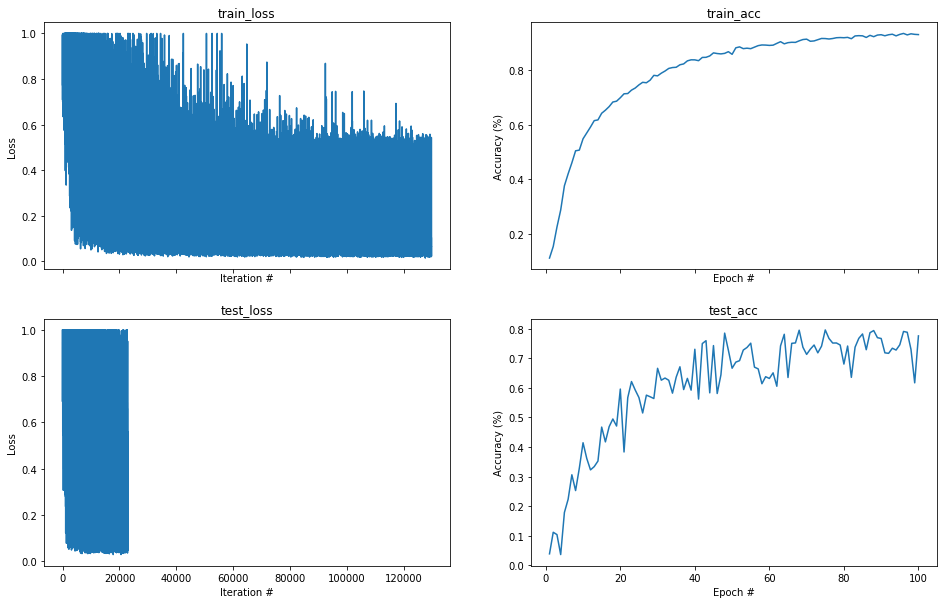

In [ ]:
#from cs236605.plot import plot_fit
plot_fit(fit_res)

### Show the dice score and training/testing accuracy plot

In [ ]:
print("Best dice score: %.2f" % fit_res.best_score)

Best dice score: 0.80


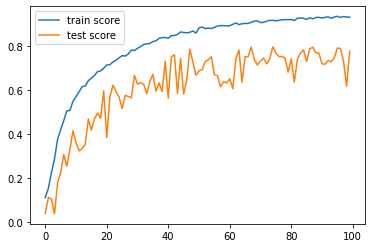

In [ ]:
import matplotlib.pyplot as plt
plt.plot(fit_res.train_acc)
plt.plot(fit_res.test_acc)
plt.legend(['train score', 'test score'])
plt.show()